In [0]:
project_name = 'test_project_1'
#permissions='default'
permissions='fulldata'

In [0]:
pip install pycountry

Python interpreter will be restarted.
Python interpreter will be restarted.


In [0]:
%pip install markupsafe==2.0.1
%pip install rpy2

Python interpreter will be restarted.
Python interpreter will be restarted.
Python interpreter will be restarted.
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'error'
  ERROR: Command errored out with exit status 1:
   command: /local_disk0/.ephemeral_nfs/envs/pythonEnv-9680b7db-40d6-4a56-8abd-3c4b40756c93/bin/python /local_disk0/.ephemeral_nfs/envs/pythonEnv-9680b7db-40d6-4a56-8abd-3c4b40756c93/lib/python3.9/site-packages/pip/_vendor/pep517/in_process/_in_process.py get_requires_for_build_wheel /tmp/tmpob06m228
       cwd: /tmp/pip-install-57kpgi5x/rpy2_14ca9415357e4d7b81ba8d612a402478
  Complete output (16 lines):
  Traceback (most recent call last):
    File "/local_disk0/.ephemeral_nfs/envs/pythonEnv-9680b7db-40d6-4a56-8abd-3c4b40756c93/lib/python3.9/site-packages/pip/_vendor/pep517/in_process/_in_process.py", line 349, 

In [0]:
%run /Snippets/header_008

PROJECT DETAILS:
Project identifier: test_project_1
Cluster data access level: fulldata


EXECUTION DETAILS:
Spark version: 11.3.x-scala2.12, 
Cluster Node Type: i3.xlarge, 
Driver Node Type: c4.2xlarge, 
Worker Node Type: i3.xlarge


DATA SNAPSHOT DETAILS:
This notebook uses the latest snapshot date for this version: "v008.20231003094404/", (03 October 2023)

 The following are the Scopus snapshot dates available for datasets at v008:
['v008.20220314092239/', 'v008.20220906063204/', 'v008.20221021151538/', 'v008.20230509104116/', 'v008.20230821105000/', 'v008.20231003094404/']
(If you want to use a different snapshot, in the first cell of your notebook, set the variable `custom_snapshot_date` to one of the options listed above (string data type))



DATA SAMPLE DETAILS:
Setting paths to run on full datasets (100% Scopus publication volume)


In [0]:
import pandas as pd
import pyspark.sql.functions as F
def first(lst):
  return lst[0]
def extract_publication_info(newdf):
  #newdf = df_ani.limit(50)
  newdf = newdf.select('doi','Eid','year','Au','Au_Af','Au_cors','publication_type','openaccess','issn','source','news_cnt','correspondence','Af')


  newdf = newdf.withColumn('Au1', first(newdf['Au']))



  newdf = newdf.withColumn('Au2', F.element_at(newdf['Au'], -1))

  newdf = newdf.withColumn('num_au', F.size(newdf['Au']))

  newdf = newdf.withColumn('Au1_id', F.col('Au1').getItem('auid'))

  newdf = newdf.withColumn('Au2_id', F.col('Au2').getItem('auid'))

  newdf = newdf.withColumn('Au_cor_id', F.col('Au_cors').getItem('auid'))
  #newdf = newdf.withColumn('Au_cor_name', F.col('Au_cors').getItem('given_name'))
  #newdf = newdf.withColumn('cor1_given_name', first(newdf['Au_cor_name']))

  newdf = newdf.withColumn('cor_seq', F.col('Au_cors').getItem('Authorseq'))
  newdf = newdf.withColumn('cor_seq_first', first(newdf['cor_seq']))

  newdf = newdf.withColumn('auth_seq', F.col('Au_Af').getItem('Authorseq'))
  newdf = newdf.withColumn('aff_seq', F.col('Au_Af').getItem('affiliation_seq'))
  newdf = newdf.withColumn("auth_pos", F.expr("array_position(auth_seq, cor_seq_first)"))

  newdf = newdf.withColumn("auth_pos", newdf["auth_pos"].cast(IntegerType()))  
  #newdf = newdf.filter(F.col('aff_seq').isNotNull())
  newdf = newdf.filter(F.col('auth_pos') != 0)
  newdf = newdf.withColumn("aff", F.element_at(newdf['aff_seq'], newdf['auth_pos']))
  newdf = newdf.withColumn("aff_val", F.element_at(newdf['Af'], newdf['aff']))
  newdf = newdf.withColumn("cor_afid", F.col('aff_val').getItem('afid'))

  newdf = newdf.withColumn('given_seq', F.col('Au').getItem('given_name'))
  newdf = newdf.withColumn("cor1_given_name", F.element_at(newdf['given_seq'], newdf['cor_seq_first']))
  display(newdf.limit(10))

  return newdf
def get_smc_classification(newdf):
  df_smc_ani = spark.read.format("parquet").load(basePath+tablename_smc_complete)
  newdf2 = newdf.join(df_smc_ani,'Eid', 'inner')
  return newdf2

def get_gender(newdf):
  df_gender = spark.read.format("parquet").load(basePath+tablename_gender_inference)
  #non_null_count = newdf.where(F.col('Au1_id').isNotNull()).count()
  mergedf = df_gender.join(newdf, newdf.Au1_id == df_gender.auid, 'inner').select(
      df_gender.Inferred_Probable_Gender,newdf.doi,newdf.news_cnt,newdf.Au,newdf.Eid, newdf.year, newdf.publication_type,newdf.openaccess, newdf.issn, 
      newdf.num_au, newdf.Au1_id,newdf.Au2_id,newdf.Au_cor_id, newdf.srcid, newdf.subfield_article, newdf.subfield_journal, newdf.subfield_hybrid,newdf.correspondence,
      newdf.cor1_given_name, newdf.cor_afid)
  mergedf = mergedf.withColumnRenamed('Inferred_Probable_Gender', 'Au1_gender')

  mergedf2 = df_gender.join(mergedf, mergedf.Au2_id == df_gender.auid, 'inner').select(
      df_gender.Inferred_Probable_Gender, mergedf.doi,mergedf.news_cnt,mergedf.Au,mergedf.Eid, mergedf.year, mergedf.publication_type,mergedf.openaccess, mergedf.issn, 
      mergedf.num_au, mergedf.Au1_id,mergedf.Au2_id,mergedf.Au_cor_id, mergedf.srcid, mergedf.subfield_article, mergedf.subfield_journal, mergedf.subfield_hybrid, mergedf.Au1_gender,mergedf.correspondence,mergedf.cor1_given_name,mergedf.cor_afid)
  mergedf2 = mergedf2.withColumnRenamed('Inferred_Probable_Gender', 'Au2_gender')

  #mergedf2 = mergedf2.withColumn('no_cor', F.size(mergedf2['Au_cor_id']))
  #display("len os final4 ", mergedf2.count(),"\n")

  mergedf2 = mergedf2.withColumn('cor_au1', first(mergedf2['Au_cor_id']))

  #display(final_data4.limit(20))

  mergedf3 = mergedf2.filter(F.col('cor_au1').isNotNull())
  display("no of not null cor au",mergedf3.count(),"\n")

  mergedf4 = df_gender.join(mergedf3, mergedf3.cor_au1 == df_gender.auid, 'inner').select(
      df_gender.Inferred_Probable_Gender, mergedf3.doi,mergedf3.news_cnt,mergedf3.Au,mergedf3.Eid, mergedf3.year, mergedf3.publication_type,mergedf3.openaccess, mergedf3.issn, 
      mergedf3.num_au, mergedf3.Au1_id,mergedf3.Au2_id,mergedf3.Au_cor_id, mergedf3.srcid, mergedf3.subfield_article, mergedf3.subfield_journal, mergedf3.subfield_hybrid, mergedf3.Au1_gender,mergedf3.Au2_gender,mergedf3.cor_au1,mergedf3.correspondence,mergedf3.cor1_given_name, mergedf3.cor_afid)
  mergedf4 = mergedf4.withColumnRenamed('Inferred_Probable_Gender', 'cor_gender')

  return mergedf4

def merge_news_cnt(scop):
  scop = scop.filter(func.col('year') >= 2013)
  scop = scop.filter(func.col('year') <= 2017)
  df1 = spark.read.format("csv").option("header", "true").load("dbfs:/FileStore/shared_uploads/arabi2@wisc.edu/doi_news_final_cycle2.csv")
  display("# doi data from crossref and altmetric ",df1.count(),"\n")
  df = scop.join(df1, 'doi','inner')
  df = df.withColumn("news_cnt", df["news_cnt"].cast(IntegerType()))
  return df

from pyspark.sql.functions import lower

df_ani = spark.read.format("parquet").load(basePath+tablename_ani)

display("len of df_ani ",df_ani.count(),"\n")
dd = df_ani.withColumn('language', first(df_ani['meta_language']))
d1 = dd.withColumn('language_s', lower(dd['language']))

d2 = d1.filter(func.col('language_s') == 'english')
display("len of df_ani in english ",d2.count(),"\n")

with_news = merge_news_cnt(d2)
display("merged data len between crossref and scopus ",with_news.count(),"\n")

newdf = extract_publication_info(with_news)

df_class = get_smc_classification(newdf)
final_data = get_gender(df_class)
display(final_data.count(),"\n")
final_data2 = final_data.dropna(subset=["doi"])
display(final_data2.count(),"\n")

##extracting sci_val topic for each publication
df_top_eids = spark.read.format("parquet").load(basePath+tablename_top_topic_eid)

final_data3 = final_data2.join(df_top_eids,'Eid','inner')
#display(final_data3.count())
display(final_data3.limit(10))


import pyspark.sql.functions as F
import pyspark.sql.column as C

def find_sjr(met,yy,yr):

  ylst = F.tolist(yy)

  #index = ylst.index(yr)
  #sjr = m[index]
  return m


df_sources = spark.read.format("parquet").load(basePath+tablename_sources)

data = final_data3.join(df_sources,'srcid','inner').select(df_sources.metrics_calculations,df_sources.sourcetitle,df_sources.openaccess_status,final_data3.srcid,final_data3.doi,final_data3.news_cnt,final_data3.year,
final_data3.publication_type, final_data3.issn, final_data3.num_au,final_data3.Au1_id, final_data3.subfield_article,final_data3.subfield_journal, final_data3.Au1_gender,final_data3.TopicId, 
final_data3.cor_gender,final_data3.cor_au1,final_data3.correspondence, final_data3.cor1_given_name, final_data3.cor_afid)

display("len of merged data between src ", data.count(),"\n")

data = data.withColumn('SJR_lst', F.col('metrics_calculations').getItem('SJR'))
data = data.withColumn('year_SJR', F.col('metrics_calculations').getItem('year'))

#data = data.withColumn('SJR', find_sjr(data['SJR_lst'],data['year_SJR'], data['year']))
data = data.withColumn("pos", F.expr("array_position(year_SJR, year)"))


data = data.withColumn("pos", data["pos"].cast(IntegerType()))  
data = data.withColumn("SJR", F.element_at(data['SJR_lst'], data['pos']))

data = data.withColumn('cor_af', first(data['correspondence']))
data = data.withColumn('cor_coun', F.col('cor_af').getItem('country'))



import pycountry
import pyspark.sql.functions as F

def convert_country_short_name(country_short_name):
  #country = pycountry.countries.get(alpha_2=country_short_name)
  if len(country_short_name) == 3:
    country = pycountry.countries.get(alpha_3=country_short_name)
  else:
    country = pycountry.countries.get(alpha_2=country_short_name)

  return country.name if country else None

@F.udf(returnType=F.StringType())
def my_udf(country_short_name):
  return convert_country_short_name(country_short_name)

data = data.filter(F.col('cor_coun').isNotNull())
data = data.withColumn("country_name", my_udf(data["cor_coun"]))
#un_full_coun = un_name.withColumn("country_name", my_udf(un_name["cor_coun"]))

df_ipr = spark.read.format("parquet").load(basePath+tablename_ipr)
data = data.join(df_ipr,[data.cor_afid == df_ipr.afid],'inner')
display(data.limit(10))

val_data = data.filter(func.col('cor_gender') != 'unknown')

#val_un = data.filter(func.col('cor_gender') == 'unknown')



display("len of data whose cor_gender is not unknown ",val_data.count(),"\n")

display(val_data.limit(5),"\n")


#val_un = data.filter(func.col('cor_gender') == 'unknown')
df_apr = spark.read.format("parquet").load(basePath+tablename_apr)
#un_full_coun = val_un.join(df_apr,val_un.cor_au1 == df_apr.auid,'inner')
un_full_coun = data.filter(func.col('cor_gender') == 'unknown')

display("len of unknown name ", un_full_coun.count(),"\n")

un_full_coun = un_full_coun.filter(F.col('cor1_given_name').isNotNull())
un_full_coun = un_full_coun.filter(F.col('country_name').isNotNull())
display("len of unknown name after dropping null country and given name ", un_full_coun.count(),"\n")

df_wos = spark.read.format("csv").option("header", "true").load("dbfs:/FileStore/shared_uploads/arabi2@wisc.edu/wos_gender_firstname.csv")
#df_wos.printSchema()
#df_wos = df_wos.filter(func.col('country') == 'China')
newfile = un_full_coun.join(df_wos,[un_full_coun.cor1_given_name == df_wos.givenname,un_full_coun.country_name == df_wos.country],'inner')
display("len or merged gender with wos ", newfile.count(),"\n")

'len of df_ani '95242081'\n''len of df_ani in english '83156711'\n''# doi data from crossref and altmetric '16852888'\n''merged data len between crossref and scopus '4555328'\n'

doi Eid year Au Au_Af Au_cors publication_type openaccess issn source news_cnt correspondence Af Au1 Au2 num_au Au1_id Au2_id Au_cor_id cor_seq cor_seq_first auth_seq aff_seq auth_pos aff aff_val cor_afid given_seq cor1_given_name 10.1001/jama.2012.176143 84874434288 2013 List(List(1, 36996927400, null, false, null, null, Thomas B, Thomas B., Cole T.B., Cole T., T.B., T.B., null, null, null, Cole, Cole)) List(List(1, 1, false)) List(List(1, 36996927400, null, false, null, null, null, null, Cole T.B., null, T.B., null, null, null, null, Cole, null)) ar None 15383598 List(null, null, usa, 27, 02, 27 February 2013, 2013, null, null, null, null, null, List(15383598), null, null, null, JAMA : the journal of the American Medical Association, JAMA, 85291, j, null) 0 List(List(null, null)) List(null) List(1, 36996927400, null, false, null, null, Thomas B, Thomas B., Cole T.B., Cole T., T.B., T.B., null, null, null, Cole, Cole) List(1, 36996927400, null, false, null, null, Thomas B, Thomas B., Cole T.B., Cole T., T.B., T.B., null, null, null, Cole, Cole) 1 36996927400 36996927400 List(36996927400) List(1) 1 List(1) List(1) 1 1 null null List(Thomas B) Thomas B 10.1001/jama.2013.276908 84884917245 2013 List(List(1, 6602764751, auth, false, null, 6b8f08d7710450fd1671068431198286e5dfb9f8, Reshma, Reshma, Jagsi R., Jagsi R., R., R., null, null, null, Jagsi, Jagsi)) List(List(1, 1, true)) List(List(1, 6602764751, null, false, Dr., null, null, null, Jagsi R., null, R., null, null, null, null, Jagsi, null)) sh None 00987484 List(null, null, usa, 02, 10, 2 October 2013, 2013, null, null, null, null, null, List(15383598), null, List(00987484), American Medical Association, JAMA, JAMA, 85291, j, http://jama.jamanetwork.com/data/Journals/JAMA/927789/jpo130032.pdf) 0 List(List(usa, null)) List(List(null, null, Ann Arbor, MI, United States, List(60007200, 60025778), List(Department of Radiation Oncology, Center for Bioethics and Social Science in Medicine, University of Michigan), 3, null, null, usa, null, 60007200, 126231870)) List(1, 6602764751, auth, false, null, 6b8f08d7710450fd1671068431198286e5dfb9f8, Reshma, Reshma, Jagsi R., Jagsi R., R., R., null, null, null, Jagsi, Jagsi) List(1, 6602764751, auth, false, null, 6b8f08d7710450fd1671068431198286e5dfb9f8, Reshma, Reshma, Jagsi R., Jagsi R., R., R., null, null, null, Jagsi, Jagsi) 1 6602764751 6602764751 List(6602764751) List(1) 1 List(1) List(1) 1 1 List(null, null, Ann Arbor, MI, United States, List(60007200, 60025778), List(Department of Radiation Oncology, Center for Bioethics and Social Science in Medicine, University of Michigan), 3, null, null, usa, null, 60007200, 126231870) 60007200 List(Reshma) Reshma 10.1001/jama.2013.277027 84884649413 2013 List(List(1, 7004388488, auth, false, null, 6f902786cc1c6fb5bc2c2f4202f6ab4d88e8a19b, Lewis A., Lewis A., Lipsitz L.A., Lipsitz L.A., L.A., L.A., null, null, null, Lipsitz, Lipsitz)) List(List(1, 1, true), List(1, 2, true), List(1, 3, true)) List(List(1, 7004388488, null, false, Dr. Prof., null, null, null, Lipsitz L.A., null, L.A., null, null, null, null, Lipsitz, null)) re Repository 00987484 List(null, null, usa, 25, 09, 25 September 2013, 2013, null, null, null, null, null, List(15383598), null, List(00987484), American Medical Association, JAMA, JAMA, 85291, j, http://jama.jamanetwork.com/data/Journals/JAMA/927658/jxr130007.pdf) 0 List(List(usa, null)) List(List(1200 Centre St, null, Boston, MA 02131, United States, List(60002746), List(Hebrew SeniorLife, Institute for Aging Research), 2, null, null, usa, null, 60002746, null), List(null, null, Boston, MA, United States, List(60030058), List(Division of Gerontology, Beth Israel Deaconess Medical Center), 2, null, null, usa, null, 60030058, 109179309), List(null, null, Boston, MA, United States, List(60002746), List(Department of Medicine, Harvard Medical School), 2, null, null, usa, null, 60002746, null)) List(1, 7004388488, auth, false, null, 6f902786cc1c6fb5bc2c2f4202f6ab4d88e8a19b, Lewis

'no of not null cor au'3889647'\n'3884753'\n'3884753'\n'

Eid,cor_gender,doi,news_cnt,Au,year,publication_type,openaccess,issn,num_au,Au1_id,Au2_id,Au_cor_id,srcid,subfield_article,subfield_journal,subfield_hybrid,Au1_gender,Au2_gender,cor_au1,correspondence,cor1_given_name,cor_afid,TopicId
84860270808,unknown,10.1016/j.indcrop.2012.03.036,0,"List(List(1, 57201857079, null, false, null, null, Syelvia Putri, Syelvia Putri, Utami S.P., Utami S.P., S.P., S.P., null, null, null, Utami, Utami), List(2, 35489910900, null, false, null, bd5be6f17d0109cccf498579b5db4bd0e568725c, NorAishah Saidina, Nor Aishah Saidina, Amin N.S., Amin N.A.S., N.S., N.A.S., null, null, null, Amin, Amin))",2013,ar,None,09266690,2,57201857079,35489910900,List(35489910900),32791,organic chemistry,biotechnology,biotechnology,female,unknown,35489910900,"List(List(mys, null))",NorAishah Saidina,60021005,1144
84860697281,male,10.1016/j.indcrop.2012.04.033,0,"List(List(1, 7801672235, null, false, null, 7ba9f7dc3cd9e3d1ff5ca7707c89a4b79926f17d, Víctor, Víctor, Pecina-Quintero V., Pecina-Quintero V., V., V., null, null, null, Pecina-Quintero, Pecina-Quintero), List(2, 6507406529, null, false, null, null, José Luis, José Luis, Anaya-Lopez J.L., Anaya-López J., J.L., J.L., null, null, null, Anaya-López, Anaya-López), List(3, 13411242200, null, false, null, null, Carlos Alberto, Carlos Alberto, Nunez-Colin C.A., Núñez-Colín C., C.A., C.A., null, null, null, Núñez-Colín, Núñez-Colín), List(4, 55209943500, null, false, null, null, Alfredo, Alfredo, Zamarripa-Colmenero A., Zamarripa-Colmenero A., A., A., null, null, null, Zamarripa-Colmenero, Zamarripa-Colmenero), List(5, 56013866100, null, false, null, null, Noé, Noé, Montes-Garcia N., Montes-García N., N., N., null, null, null, Montes-García, Montes-García), List(6, 36895600600, null, false, null, null, José Luis, José Luis, Solis-Bonilla J.L., Solís-Bonilla J., J.L., J.L., null, null, null, Solís-Bonilla, Solís-Bonilla), List(7, 36894420500, null, false, null, null, María Rocío, María Rocío, Aguilar-Rangel M.R., Aguilar-Rangel M., M.R., M.R., null, null, null, Aguilar-Rangel, Aguilar-Rangel))",2013,ar,None,09266690,7,7801672235,36894420500,List(7801672235),32791,plant biology & botany,biotechnology,biotechnology,male,female,7801672235,"List(List(mex, null))",Víctor,60017983,23719
84860782470,male,10.1099/ijs.0.036434-0,0,"List(List(1, 26327148900, null, false, null, null, Gernot, Gernot, Rieser G., Rieser G., G., G., null, null, null, Rieser, Rieser), List(2, 7201935738, null, false, null, 4505352b1f0bbea6a79ab23de5278eddc26ee4d3, Siegfried, Siegfried, Scherer S., Scherer S., S., S., null, null, null, Scherer, Scherer), List(3, 12544819000, null, false, null, null, Mareike, Mareike, Wenning M., Wenning M., M., M., null, null, null, Wenning, Wenning))",2013,ar,None,14665026,3,26327148900,12544819000,List(7201935738),19761,microbiology,microbiology,microbiology,male,female,7201935738,"List(List(deu, null))",Siegfried,60019722,46530
84862297631,male,10.1080/00036846.2012.681029,0,"List(List(1, 6701676884, null, false, null, null, James Peery, James Peery, Cover J.P., Cover J., J.P., J.P., null, null, null, Cover, Cover), List(2, 57208798604, null, false, null, cb833df658641f5899e98cbac21e76c8047ac314, Eric, Eric, Olson E., Olson E., E., E., null, null, null, Olson, Olson))",2013,ar,None,00036846,2,6701676884,57208798604,List(57208798604),18768,economics,economics,economics,male,male,57208798604,"List(List(usa, null))",Eric,60026451,4419
84863832767,male,10.1016/j.ribaf.2012.05.002,0,"List(List(1, 24080920300, null, false, null, 6316b93686e7997a872abe800acca7ef7da3d48f, Miroslav, Miroslav, Mateev M., Mateev M., M., M., null, null, null, Mateev, Mateev), List(2, 6602300671, null, false, null, ff422f3b90239e580022d14558818e4f50f6ba5e, Panikkos, Panikkos, Poutziouris P., Poutziouris P., P., P., null, null, null, Poutziouris, Poutziouris), List(3, 55313530500, null, false, null, 54290654d80621dc8bfabf30aeaf2943a75a3e0b, Konstantin, Konstantin, Ivanov K., Ivanov K., K., K., null, nul

'len of merged data between src '3821679'\n'

metrics_calculations sourcetitle openaccess_status srcid doi news_cnt year publication_type issn num_au Au1_id subfield_article subfield_journal Au1_gender TopicId cor_gender cor_au1 correspondence cor1_given_name cor_afid SJR_lst year_SJR pos SJR cor_af cor_coun country_name afid preferred_name sort_name address_part postal_code city state country country_tag name_variant org_domain org_type parent parent_preferred_name List(List(null, null, 4165.0, 2923.0, null, 387, 0.0, Complete, 1996, 3, 4), List(null, null, 4472.0, 3179.0, null, 392, 0.0, Complete, 1997, 6, 6), List(null, null, 4290.0, 3362.0, null, 262, 0.38, Complete, 1998, 2, 2), List(0.833, 1.387, 5145.0, 3688.0, null, 391, 0.26, Complete, 1999, 3, 3), List(1.067, 1.167, 5491.0, 4454.0, null, 240, 0.0, Complete, 2000, 2, 2), List(0.941, 1.477, 5970.0, 4510.0, null, 372, 0.0, Complete, 2001, 0, 0), List(0.959, 1.286, 6021.0, 5083.0, null, 240, 0.0, Complete, 2002, 0, 0), List(1.102, 1.808, 7130.0, 5931.0, null, 325, 0.0, Complete, 2003, 1, 1), List(1.373, 1.937, 8848.0, 7535.0, null, 277, 0.0, Complete, 2004, 1, 1), List(1.458, 1.972, 10086.0, 8366.0, null, 393, 0.0, Complete, 2005, 2, 2), List(1.437, 1.967, 12548.0, 11004.0, null, 325, 0.62, Complete, 2006, 4, 4), List(1.269, 1.861, 11939.0, 10036.0, null, 384, 0.0, Complete, 2007, 3, 4), List(1.585, 1.842, 13806.0, 11984.0, null, 380, 0.0, Complete, 2008, 2, 2), List(1.649, 2.067, 16434.0, 14009.0, null, 467, 0.21, Complete, 2009, 7, 7), List(1.475, 2.128, 18005.0, 16186.0, null, 317, 0.0, Complete, 2010, 3, 3), List(1.526, 2.802, 19867.0, 17037.0, List(List(5632, 3.4, 66, 1645, List(List(2211, List(296, 37), 87), List(2508, List(91, 15), 84), List(2505, List(233, 40), 83), List(3104, List(383, 85), 77), List(3110, List(49, 12), 76)))), 504, 0.0, Complete, 2011, 6, 7), List(1.345, 2.118, 19630.0, 17860.0, List(List(5362, 3.5, 72, 1522, List(List(2211, List(305, 36), 88), List(2508, List(93, 15), 84), List(2505, List(234, 44), 81), List(3110, List(49, 11), 78), List(3104, List(387, 85), 78)))), 258, 0.0, Complete, 2012, 0, 0), List(1.317, 2.34, 24916.0, 21836.0, List(List(5007, 3.2, 69, 1572, List(List(2211, List(309, 57), 81), List(2508, List(96, 19), 80), List(2505, List(240, 51), 78), List(3110, List(49, 14), 72), List(3104, List(388, 110), 71)))), 512, 0.0, Complete, 2013, 8, 9), List(1.711, 2.285, 24786.0, 22835.0, List(List(6202, 4.1, 78, 1524, List(List(2211, List(318, 34), 89), List(2508, List(101, 15), 85), List(2505, List(249, 39), 84), List(3104, List(395, 73), 81), List(3110, List(49, 10), 80)))), 275, 0.0, Complete, 2014, 2, 3), List(1.512, 2.071, 25880.0, 22996.0, List(List(5948, 4.2, 75, 1407, List(List(2211, List(324, 36), 89), List(2508, List(105, 14), 87), List(2505, List(253, 34), 86), List(3110, List(49, 8), 84), List(3104, List(401, 76), 81)))), 401, 0.0, Complete, 2015, 9, 10), List(1.588, 2.127, 28039.0, 25884.0, List(List(7614, 5.3, 80, 1437, List(List(2211, List(329, 29), 91), List(2505, List(253, 28), 89), List(2508, List(110, 13), 88), List(3104, List(402, 53), 86), List(3110, List(50, 8), 85)))), 283, 0.0, Complete, 2016, 2, 2), List(1.386, 2.225, 30788.0, 27883.0, List(List(6589, 4.4, 68, 1513, List(List(2508, List(117, 20), 83), List(2211, List(353, 66), 81), List(2505, List(270, 52), 80), List(3104, List(395, 83), 79), List(3110, List(49, 12), 76)))), 445, 0.0, Complete, 2017, 6, 7), List(1.321, 2.028, 33683.0, 31588.0, List(List(8305, 5.5, 78, 1507, List(List(2505, List(275, 36), 87), List(2508, List(118, 16), 86), List(2211, List(360, 49), 86), List(3104, List(398, 60), 85), List(3110, List(54, 11), 80)))), 264, 0.76, Complete, 2018, 4, 4), List(1.335, 2.406, 38277.0, 34274.0, List(List(9027, 5.8, 76, 1552, List(List(2505, List(287, 35), 87), List(2508, List(120, 17), 86), List(2211, List(367, 52), 85), List(3104, List(403, 59), 85), List(3110, List(52, 11), 79)))), 559, 0.0, Complete, 2019, 10, 10), List(1.205, 1.94, 38181.0, 35589.0, List(List(11214, 7.2, 86, 1565, List(List(2211, L

'len of data whose cor_gender is not unknown '3191744'\n'

metrics_calculations sourcetitle openaccess_status srcid doi news_cnt year publication_type issn num_au Au1_id subfield_article subfield_journal Au1_gender TopicId cor_gender cor_au1 correspondence cor1_given_name cor_afid SJR_lst year_SJR pos SJR cor_af cor_coun country_name afid preferred_name sort_name address_part postal_code city state country country_tag name_variant org_domain org_type parent parent_preferred_name List(List(null, null, 0.0, 0.0, null, 0, 0.0, Complete, 1996, 0, 0), List(null, null, 0.0, 0.0, null, 0, 0.0, Complete, 1997, 0, 0), List(null, null, 0.0, 0.0, null, 0, 0.0, Complete, 1998, 0, 0), List(null, null, 0.0, 0.0, null, 0, 0.0, Complete, 1999, 0, 0), List(null, null, 0.0, 0.0, null, 0, 0.0, Complete, 2000, 0, 0), List(null, null, 0.0, 0.0, null, 0, 0.0, Complete, 2001, 0, 0), List(null, null, 0.0, 0.0, null, 0, 0.0, Complete, 2002, 0, 0), List(null, null, 0.0, 0.0, null, 0, 0.0, Complete, 2003, 0, 0), List(null, null, 0.0, 0.0, null, 0, 0.0, Complete, 2004, 0, 0), List(null, null, 0.0, 0.0, null, 0, 0.0, Complete, 2005, 0, 0), List(null, null, 0.0, 0.0, null, 0, 0.0, Complete, 2006, 0, 0), List(null, null, 0.0, 0.0, null, 0, 0.0, Complete, 2007, 0, 0), List(null, null, 2.0, 2.0, null, 3, 0.0, Complete, 2008, 1, 1), List(null, 0.254, 13.0, 6.0, null, 105, 39.05, Complete, 2009, 1, 1), List(0.392, 0.992, 257.0, 237.0, null, 296, 26.35, Complete, 2010, 3, 3), List(0.651, 0.87, 773.0, 769.0, List(List(774, 2.8, 89, 278, List(List(2500, List(393, 96), 75)))), 80, 6.25, Complete, 2011, 2, 2), List(0.841, 1.438, 1437.0, 1419.0, List(List(1955, 3.8, 72, 512, List(List(2500, List(408, 67), 83)))), 144, 20.83, Complete, 2012, 4, 4), List(1.001, 1.612, 2457.0, 2352.0, List(List(3358, 3.9, 59, 856, List(List(2500, List(420, 62), 85)))), 358, 8.38, Complete, 2013, 3, 4), List(0.767, 1.188, 4159.0, 3971.0, List(List(2356, 2.4, 55, 986, List(List(2500, List(430, 148), 65)))), 458, 14.85, Complete, 2014, 4, 4), List(0.83, 1.459, 6349.0, 6089.0, List(List(5170, 3.5, 60, 1491, List(List(2500, List(437, 107), 75)))), 588, 8.84, Complete, 2015, 9, 12), List(0.838, 1.505, 9371.0, 8850.0, List(List(9071, 3.8, 59, 2390, List(List(2500, List(435, 108), 75)))), 1030, 7.28, Complete, 2016, 10, 12), List(0.732, 1.318, 13653.0, 12769.0, List(List(12047, 3.4, 62, 3527, List(List(2500, List(444, 144), 67)))), 1498, 6.94, Complete, 2017, 11, 15), List(0.686, 1.251, 21060.0, 19027.0, List(List(18389, 3.2, 64, 5685, List(List(2500, List(440, 168), 61)))), 2656, 5.38, Complete, 2018, 31, 39), List(0.647, 1.227, 33225.0, 29732.0, List(List(32780, 3.5, 64, 9261, List(List(2500, List(460, 173), 62), List(3104, List(403, 152), 62)))), 4169, 5.33, Complete, 2019, 57, 86), List(0.682, 1.256, 54882.0, 48365.0, List(List(58173, 4.2, 70, 14002, List(List(3104, List(411, 135), 67), List(2500, List(455, 159), 65)))), 5838, 5.55, Complete, 2020, 164, 239), List(0.604, 1.126, 81251.0, 71492.0, List(List(95860, 4.7, 70, 20325, List(List(3104, List(415, 132), 68), List(2500, List(455, 166), 63)))), 7880, 5.62, Complete, 2021, 523, 785), List(0.563, 1.067, 113727.0, 101178.0, List(List(139478, 5.2, 74, 26640, List(List(3104, List(423, 125), 70), List(2500, List(453, 163), 64)))), 9074, 5.87, Complete, 2022, 2000, 2693), List(null, null, 98765.0, 90072.0, List(List(142475, 5.1, 76, 28131, List(List(3104, List(423, 118), 72), List(2500, List(452, 153), 66)))), 5711, 7.41, In-Progress, 2023, 3886, 4306)) Materials YES 76627 10.3390/ma7021142 0 2014 ar 19961944 2 57202426704 analytical chemistry materials female 36193 male 35594274200 List(List(jpn, null)) Yasushi 60000011 List(null, null, null, null, null, null, null, null, null, null, null, null, null, null, 0.392, 0.651, 0.841, 1.001, 0.767, 0.83, 0.838, 0.732, 0.686, 0.647, 0.682, 0.604, 0.563, null) List(1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023) 19 0.767 List(jpn, null) jpn 

'len of unknown name '571173'\n''len of unknown name after dropping null country and given name '534315'\n''len or merged gender with wos '328189'\n'

In [0]:
ddf2 = newfile.drop("cor_gender")
ddf3 = ddf2.withColumnRenamed("gender", "cor_gender")
#ddf3.printSchema()
#display(ddf3.select('cor_gender').distinct())
ddf4 = ddf3.select('srcid','openaccess_status','doi','news_cnt','year','issn','num_au','cor_gender','TopicId','Au1_gender','country_name','SJR','subfield_article','preferred_name','org_type').toPandas()
print(ddf4.head(5)) 

ddfx = val_data.select('srcid','openaccess_status','doi','news_cnt','year','issn','num_au','cor_gender','TopicId','Au1_gender','country_name','SJR','subfield_article','preferred_name','org_type').toPandas()
display(len(ddfx),"\n")
display(len(ddf4),"\n")
ddf = ddfx.append(ddf4, ignore_index = True)
display(len(ddf),"\n")

         srcid openaccess_status                         doi  news_cnt  year  \
0        12459                NO         10.1093/jnci/djt310         1  2013   
1  21100406908                NO   10.1016/j.euf.2016.06.015         0  2017   
2        19975                NO  10.1016/j.juro.2014.01.088         0  2014   
3        28785                NO          10.1002/cncr.29765         2  2016   
4        23909                NO          10.1039/c4an02124j         0  2015   

       issn  num_au cor_gender  TopicId Au1_gender   country_name    SJR  \
0  00278874      17          M    18459    unknown  United States  7.115   
1  24054569      22          M    29535    unknown  United States  0.663   
2  00225347      12          M     6127    unknown  United States  2.278   
3  0008543X      18          M    29535    unknown  United States  3.068   
4  00032654       2          M     8711       male  United States  1.229   

            subfield_article                          preferre

In [0]:
smc = spark.read.format("csv").option("header", "true").load("dbfs:/FileStore/shared_uploads/arabi2@wisc.edu/sm_journal_classification.csv")
smc = smc.select('Domain_English','Field_English','SubField_English').toPandas()
smc = smc.dropna()
smc = smc.drop_duplicates()
print(len(smc))
smc['SubField_English'] = smc['SubField_English'].str.lower()
ddf['subfield_article'] = ddf['subfield_article'].str.lower()

#print(smc.dtypes)
total = smc.merge(ddf,left_on='SubField_English',right_on = 'subfield_article',how = 'inner')
print(len(total))

175
3511061


In [0]:
us = total[total['country_name'] == 'United States']
print(len(us))
us.to_csv("/dbfs/FileStore/shared_uploads/arabi2@wisc.edu/us2.csv", index = False)

858293


In [0]:
#dbutils.fs.rm("dbfs:/FileStore/shared_uploads/arabi2@wisc.edu/us2.csv", recurse = True)

# read the saved us file and do preliminary analysis

In [0]:
import pandas as pd
total = pd.read_csv("/dbfs/FileStore/shared_uploads/arabi2@wisc.edu/us2.csv")
print(total.dtypes)

print("len of total ", len(total))
print(total['doi'].nunique())

Domain_English        object
Field_English         object
SubField_English      object
srcid                  int64
openaccess_status     object
doi                   object
news_cnt               int64
year                   int64
issn                  object
num_au                 int64
cor_gender            object
TopicId                int64
Au1_gender            object
country_name          object
SJR                  float64
subfield_article      object
preferred_name        object
org_type              object
dtype: object
len of total  858293
857876


# US only total distribution of gender

858293
male  0.6696151547315428  female  0.3303848452684573


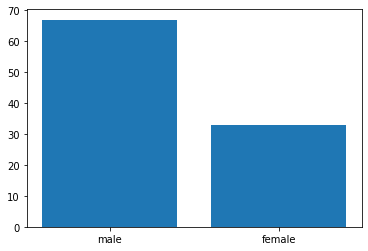

In [0]:
us = total[total['country_name'] == 'United States']
print(len(us))

import matplotlib.pyplot as plt 

m = len(us[us['cor_gender'] == 'male']) + len(us[us['cor_gender'] == 'M']) + len(us[us['cor_gender'] == 'm'])
f = len(us[us['cor_gender'] == 'female']) + len(us[us['cor_gender'] == 'F']) + len(us[us['cor_gender'] == 'f'])

print("male ",m/len(us)," female ",f/len(us))

dd = pd.DataFrame()
dd['gender'] =['male', 'female']
dd['dist'] = [(m/len(us))*100,(f/len(us))*100]
plt.bar(dd['gender'], dd['dist'])
plt.show()

# distribution of gender in US, cited group

110137
male  0.6506169588784877  female  0.3493830411215123


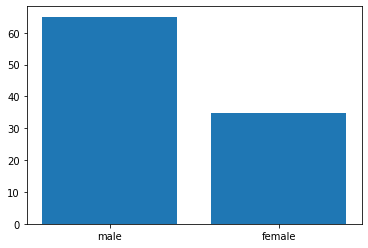

In [0]:
us = total[total['country_name'] == 'United States']
us = us[us['news_cnt'] > 0]
us = us.drop_duplicates()
print(len(us))

import matplotlib.pyplot as plt 

m = len(us[us['cor_gender'] == 'male']) + len(us[us['cor_gender'] == 'M']) + len(us[us['cor_gender'] == 'm'])
f = len(us[us['cor_gender'] == 'female']) + len(us[us['cor_gender'] == 'F']) + len(us[us['cor_gender'] == 'f'])

print("male ",m/len(us)," female ",f/len(us))

dd = pd.DataFrame()
dd['gender'] =['male', 'female']
dd['dist'] = [(m/len(us))*100,(f/len(us))*100]
plt.bar(dd['gender'], dd['dist'])
plt.show()

748083
male  0.6724160287026975  female  0.32758397129730255


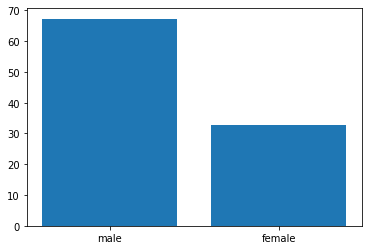

In [0]:
us = total[total['country_name'] == 'United States']
us = us[us['news_cnt'] == 0]
us = us.drop_duplicates()
print(len(us))

import matplotlib.pyplot as plt 

m = len(us[us['cor_gender'] == 'male']) + len(us[us['cor_gender'] == 'M']) + len(us[us['cor_gender'] == 'm'])
f = len(us[us['cor_gender'] == 'female']) + len(us[us['cor_gender'] == 'F']) + len(us[us['cor_gender'] == 'f'])

print("male ",m/len(us)," female ",f/len(us))

dd = pd.DataFrame()
dd['gender'] =['male', 'female']
dd['dist'] = [(m/len(us))*100,(f/len(us))*100]
plt.bar(dd['gender'], dd['dist'])
plt.show()

# percent of cited female stratified by year

In [0]:
us = total[total['country_name'] == 'United States']
print(us['year'].unique())

y_19 = us[us['year'] <= 2014]

y_20 = us[us['year'] >= 2015]


cited_19 = y_19[y_19['news_cnt'] > 0]
f_19 = len(cited_19[cited_19['cor_gender'] == 'female']) + len(cited_19[cited_19['cor_gender'] == 'F']) + len(cited_19[cited_19['cor_gender'] == 'f'])

cited_20 = y_20[y_20['news_cnt'] > 0]
f_20 = len(cited_20[cited_20['cor_gender'] == 'female']) + len(cited_20[cited_20['cor_gender'] == 'F']) + len(cited_20[cited_20['cor_gender'] == 'f'])

print("percent of female in cited group in year 2013-2014 ", f_19/len(cited_19))
print("percent of female in cited group in year 2015-2017 ", f_20/len(cited_20))

[2015 2017 2013 2014 2016]
percent of female in cited group in year 2013-2014  0.3410503751339764
percent of female in cited group in year 2015-2017  0.35287589206209913


# us only, percent of female correnponding author based on field classification

domain  ['Agriculture, Fisheries & Forestry' 'Built Environment & Design'
 'Enabling & Strategic Technologies' 'Engineering'
 'Information & Communication Technologies'
 'Communication & Textual Studies' 'Historical Studies'
 'Philosophy & Theology' 'Visual & Performing Arts'
 'Economics & Business ' 'Social Sciences' 'Biomedical Research'
 'Clinical Medicine' 'Psychology & Cognitive Sciences'
 'Public Health & Health Services' 'Biology' 'Chemistry'
 'Earth & Environmental Sciences' 'Mathematics & Statistics'
 'Physics & Astronomy']
female percent  [34.80552070263488, 32.75910759672409, 21.455679637061596, 20.893013738672902, 25.110194795961892, 50.463067540094876, 43.11986863711002, 27.84757118927973, 37.72241992882562, 28.66300003956792, 48.535586815032545, 32.54775274808664, 32.62796435465153, 51.297824024835435, 59.256818520014455, 33.87688544639217, 18.929993248434336, 31.32835422779408, 19.450150102701848, 18.213082703224742]


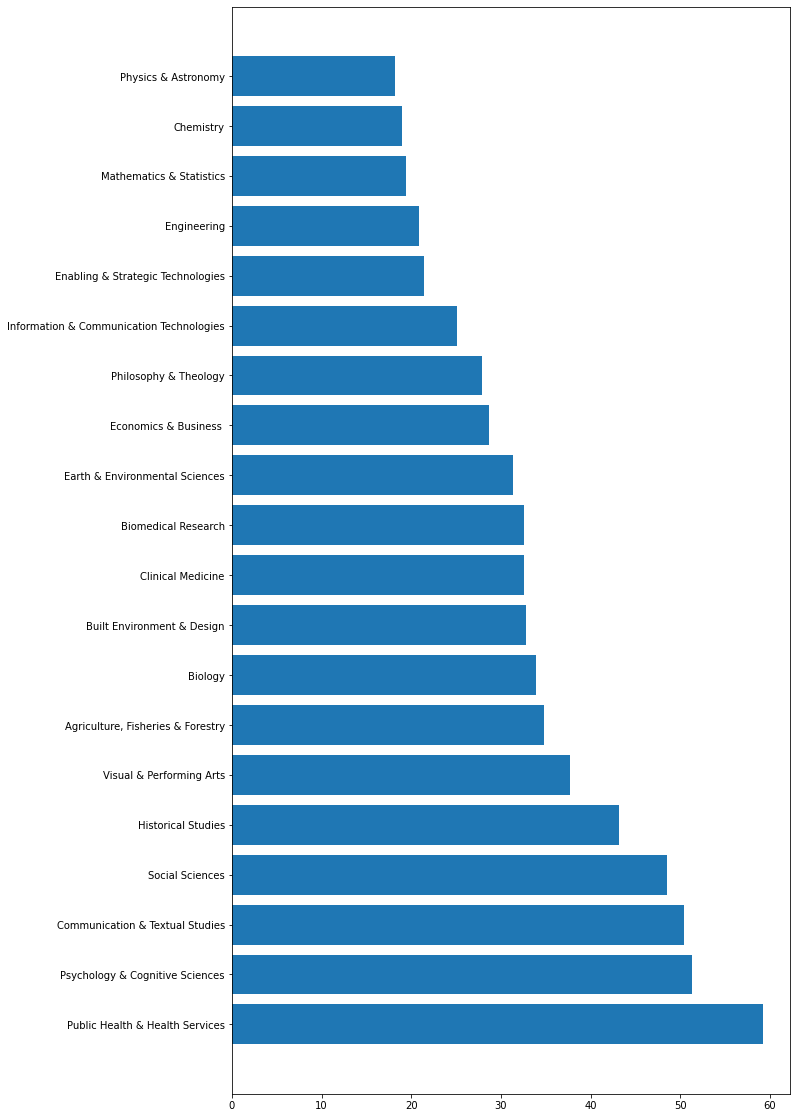

In [0]:
us = total[total['country_name'] == 'United States']
domain = us['Field_English'].unique()
female = []

for i in domain:
  tc = us[us['Field_English'] == i]
  #tc = tc[tc['news_cnt'] > 0]
  tc_female = len(tc[tc['cor_gender'] == 'female']) + len(tc[tc['cor_gender'] == 'F']) + len(tc[tc['cor_gender'] == 'f'])
  female.append((tc_female/len(tc))*100)

print("domain ",domain)
print("female percent ", female)
fig = plt.figure(figsize =(10, 20))
 
samp = pd.DataFrame()
samp['domain'] = domain
samp['female'] = female

samp = samp.sort_values(by = ['female'], ascending=False)

plt.barh(samp['domain'], samp['female'])

plt.show()

# us only, percent of female correnponding author in the cited group based on field classification

domain  ['Agriculture, Fisheries & Forestry' 'Built Environment & Design'
 'Enabling & Strategic Technologies' 'Engineering'
 'Information & Communication Technologies'
 'Communication & Textual Studies' 'Historical Studies'
 'Philosophy & Theology' 'Visual & Performing Arts'
 'Economics & Business ' 'Social Sciences' 'Biomedical Research'
 'Clinical Medicine' 'Psychology & Cognitive Sciences'
 'Public Health & Health Services' 'Biology' 'Chemistry'
 'Earth & Environmental Sciences' 'Mathematics & Statistics'
 'Physics & Astronomy']
female percent  [38.239074550128535, 40.55118110236221, 20.90705714866789, 23.85135135135135, 26.374859708193043, 47.977684797768475, 39.839034205231385, 35.05747126436782, 31.818181818181817, 32.57352941176471, 46.61016949152542, 32.39813811133074, 34.21443421443421, 50.09697150529614, 52.74102079395085, 33.34015136019636, 17.257769652650822, 30.14340871483729, 22.75449101796407, 18.61814345991561]


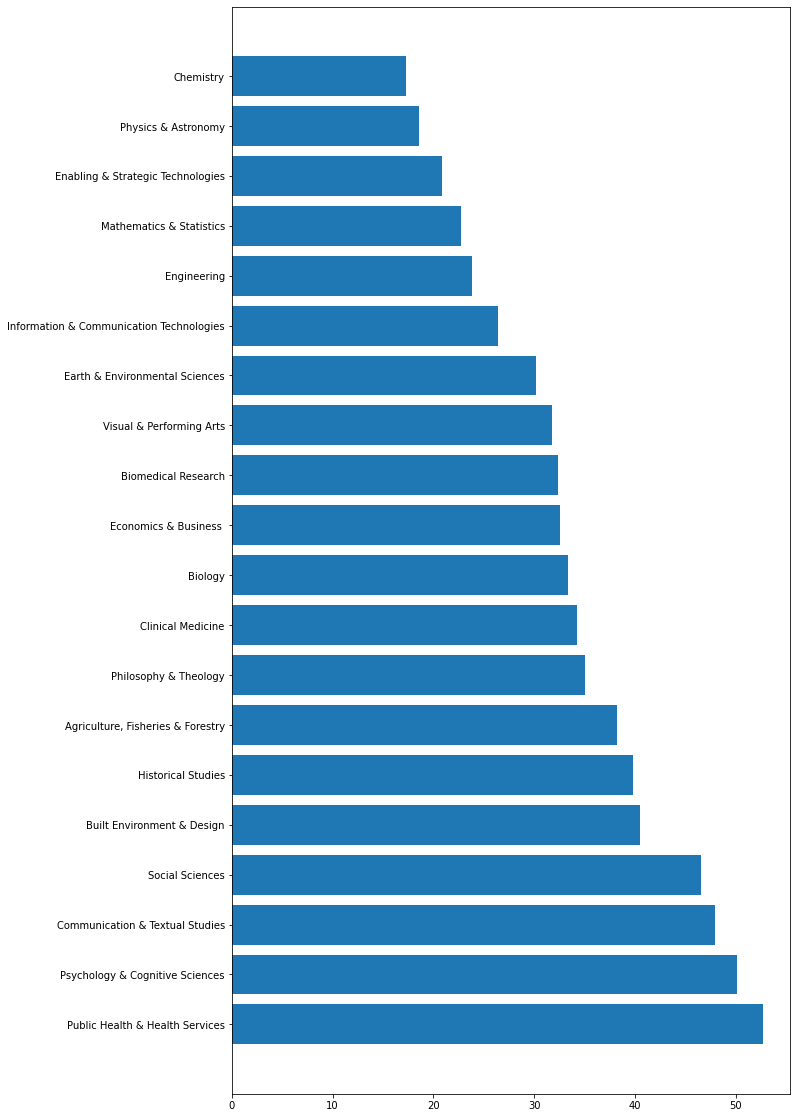

In [0]:
us = total[total['country_name'] == 'United States']
domain = us['Field_English'].unique()
female = []

for i in domain:
  tc = us[us['Field_English'] == i]
  tc = tc[tc['news_cnt'] > 0]
  tc_female = len(tc[tc['cor_gender'] == 'female']) + len(tc[tc['cor_gender'] == 'F']) + len(tc[tc['cor_gender'] == 'f'])
  female.append((tc_female/len(tc))*100)

print("domain ",domain)
print("female percent ", female)
fig = plt.figure(figsize =(10, 20))
 
samp = pd.DataFrame()
samp['domain'] = domain
samp['female'] = female

samp = samp.sort_values(by = ['female'], ascending=False)

plt.barh(samp['domain'], samp['female'])

plt.show()

# read saved file and conduct CEM matching

In [0]:
import pandas as pd
total = pd.read_csv("/dbfs/FileStore/shared_uploads/arabi2@wisc.edu/us2.csv")
print(total.dtypes)

print("len of total ", len(total))
total2 = total.dropna(subset=['srcid','year','num_au','subfield_article','cor_gender']) #replace TopicId with subfield_article
total2 = total2.drop_duplicates()


print("after dropping null and duplicates ",len(total2))

total2 = total2[total2['country_name'] == 'United States']
print("len of united states after dropping null ", len(total2))


total2['TopicId'] = total2['TopicId'].astype(str)
total2['srcid'] = total2['srcid'].astype(str)

new_yr = []
coarse_team = []
treatment = []


for ind in total2.index:
  '''if total2['year'][ind] == 2018 or total2['year'][ind] == 2019:
    new_yr.append('1')
  elif total2['year'][ind] == 2020 or total2['year'][ind] == 2021 or total2['year'][ind] == 2022:
    new_yr.append('2')'''

    
  if total2['year'][ind] == 2013:
    new_yr.append('1')
  elif total2['year'][ind] == 2014:
    new_yr.append('2')
  elif total2['year'][ind] == 2015:
    new_yr.append('3')
  elif total2['year'][ind] == 2016:
    new_yr.append('4')
  elif total2['year'][ind] == 2017:
    new_yr.append('5')
  

  
  if total2['num_au'][ind] == 1:
    coarse_team.append('1')
  elif total2['num_au'][ind] == 2:
    coarse_team.append('2')
  elif total2['num_au'][ind] == 3:
    coarse_team.append('3')
  elif total2['num_au'][ind] >= 4 and total2['num_au'][ind] <= 5:
    coarse_team.append('4')
  elif total2['num_au'][ind] >= 6 and total2['num_au'][ind] <= 9:
    coarse_team.append('5')
  elif total2['num_au'][ind] > 9:
    coarse_team.append('6')

  if total2['news_cnt'][ind] > 0:
    treatment.append('1')
  elif total2['news_cnt'][ind] == 0:
    treatment.append('0')

  


total2['year_cat'] = new_yr
total2['team_size'] = coarse_team
total2['treatment'] = treatment

print(total2.dtypes)

print(len(total2))




from collections import defaultdict


def match_data(data,treatment,control_var):

    
    ##get unique control tuples
    con_data = data[control_var] #control_var is a list of control variables, other than treatment,doi and gender
    un_con = con_data.drop_duplicates()
    
    ##create map of strata for unique control tuples
    mydict = defaultdict(list)
    cnt = 1
    '''for i, tup in enumerate(un_con.iterrows()):
        _, x_row = tup
        #print(x_row)
        mydict[tuple(x_row)] = cnt
        cnt += 1'''
    
    #print(mydict)
    new_data = data[control_var]
    strata = []
    
    for i, tup in enumerate(new_data.iterrows()):
        _, x_row = tup
        if tuple(x_row) in mydict:
            strata.append(mydict[tuple(x_row)])
        else:
            mydict[tuple(x_row)] = cnt
            cnt += 1
            strata.append(mydict[tuple(x_row)])
    data['strata'] = strata
    display("done with step 1","\n")
    
    
    
    value_counts = data["strata"].value_counts()

# Create a list of the values that have only one instance
    single_instances = value_counts[value_counts == 1].index

# Filter the DataFrame to only include rows where the "dog" value is not in the list of single_instances
    data = data[~data["strata"].isin(single_instances)]
    
    
    data["st_tr"] = data.groupby("strata")[treatment].transform(lambda x: len(x[x == '1']))

    data["st_con"] = data.groupby("strata")[treatment].transform(lambda x: len(x[x == '0']))
    
    data = data.loc[(data["st_tr"] != 0) & (data["st_con"] != 0)]
    
    st_tr = dict(zip(data['strata'], data['st_tr']))
    st_con = dict(zip(data['strata'], data['st_con']))

    display("done with step 2","\n")
    
    new = data.copy()
    
    mt = new[new[treatment] == '1']
    mc = new[new[treatment] == '0']

    new['weight'] = new['strata'].apply(lambda x: (len(mc)*st_tr[x]) / (len(mt)*st_con[x]))
    #new['weight'] = new[treatment].apply(lambda x: 1.00 if x == '1')
    row_index = new[new[treatment] == '1'].index

    # Replace all the values in the age column where the row index is in row_index with 1
    new.loc[row_index, "weight"] = 1.00
    
    
    
    
    '''weight = []
    for ind in new.index:
        s = new['strata'][ind]
        
        if new[treatment][ind] == '1':
            weight.append(1)
        else:
            ns = new[new['strata'] == s]
            mts = ns[ns[treatment] == '1']
            mcs = ns[ns[treatment] == '0']
                
            #t = new[new['strata'] != -1]
                
            
                
            weight.append((len(mc)*len(mts))/(len(mt)*len(mcs)))
    new['weight'] = weight'''
    return new
new = match_data(data = total2,treatment="treatment",control_var=['srcid','openaccess_status','year_cat','team_size','subfield_article']) #'TopicId'
#new = match_data(data = total2,treatment="treatment",control_var=['srcid','year_cat','team_size','TopicId'])


t = new[new['treatment'] == '1']
print(len(t))
c = new[new['treatment'] == '0']
print(len(c))

ft = t[t['cor_gender'] == 'female']
ft1 = t[t['cor_gender'] == 'f']
ft2 = t[t['cor_gender'] == 'F']


fc = c[c['cor_gender'] == 'female']
fc1 = c[c['cor_gender'] == 'f']
fc2 = c[c['cor_gender'] == 'F']



print((len(ft)+len(ft1)+len(ft2))/len(t)," ", (len(fc)+len(fc1)+len(fc2))/len(c)) #0.0680 more female

Domain_English        object
Field_English         object
SubField_English      object
srcid                  int64
openaccess_status     object
doi                   object
news_cnt               int64
year                   int64
issn                  object
num_au                 int64
cor_gender            object
TopicId                int64
Au1_gender            object
country_name          object
SJR                  float64
subfield_article      object
preferred_name        object
org_type              object
dtype: object
len of total  858293
after dropping null and duplicates  858220
len of united states after dropping null  858220
Domain_English        object
Field_English         object
SubField_English      object
srcid                 object
openaccess_status     object
doi                   object
news_cnt               int64
year                   int64
issn                  object
num_au                 int64
cor_gender            object
TopicId               object
Au1

# year wise analysis

In [0]:
n1 = new[new['year'] <= 2014]
n2 = new[new['year'] >= 2015]

t = n1[n1['treatment'] == '1']
c = n1[n1['treatment'] == '0']

t_female = len(t[t['cor_gender'] == 'female']) + len(t[t['cor_gender'] == 'F']) + len(t[t['cor_gender'] == 'f'])
c_female = len(c[c['cor_gender'] == 'female']) + len(c[c['cor_gender'] == 'F']) + len(c[c['cor_gender'] == 'f'])
print(((t_female/len(t)) - (c_female/len(c)))/(c_female/len(c)))


t = n2[n2['treatment'] == '1']
c = n2[n2['treatment'] == '0']

t_female = len(t[t['cor_gender'] == 'female']) + len(t[t['cor_gender'] == 'F']) + len(t[t['cor_gender'] == 'f'])
c_female = len(c[c['cor_gender'] == 'female']) + len(c[c['cor_gender'] == 'F']) + len(c[c['cor_gender'] == 'f'])
print(((t_female/len(t)) - (c_female/len(c)))/(c_female/len(c)))

0.08503926632999734
0.04512528591318048


# assign quantile

In [0]:
q1 = total['SJR'].quantile(0.25)
q2 = total['SJR'].quantile(0.50)
q3 = total['SJR'].quantile(0.75)

q = []
for ind in new.index:
  if new['SJR'][ind] <= q1:
    q.append(0)
  elif new['SJR'][ind] > q1 and new['SJR'][ind] <= q2:
    q.append(1)
  elif new['SJR'][ind] > q2 and new['SJR'][ind] <= q3:
    q.append(2)
  else:
    q.append(3)
new['q'] = q

# overall regression analysis

In [0]:
def domain(a):
  t = a[a['treatment'] == '1']
  c = a[a['treatment'] == '0']
  print("length of treatment ",len(t))
  print("length of control ",len(c))

  con_18,con_19,con_20,con_21,con_22 = [],[],[],[],[]
  t1,t2,t3,t4,t5,t6 = [],[],[],[],[],[]
  #oa = []

  out = []
  gender = []

  for ind in a.index:
    if a['year'][ind] == 2013:
      con_18.append(1)
    else:
      con_18.append(0)

    if a['treatment'][ind] == '1':
      out.append(1)
    else:
      out.append(0)

    if a['cor_gender'][ind] == 'female' or a['cor_gender'][ind] == 'f' or a['cor_gender'][ind] == 'F':
      gender.append(0)
    else:
      gender.append(1) 

  for ind in a.index:
    if a['year'][ind] == 2014:
      con_19.append(1)
    else:
      con_19.append(0)

  for ind in a.index:
    if a['year'][ind] == 2015:
      con_20.append(1)
    else:
      con_20.append(0)

  for ind in a.index:
    if a['year'][ind] == 2016:
      con_21.append(1)
    else:
      con_21.append(0)

  for ind in a.index:
    if a['year'][ind] == 2017:
      con_22.append(1)
    else:
      con_22.append(0)

  for ind in a.index:
    if a['team_size'][ind] == '1':
      t1.append(1)
    else:
      t1.append(0)

  for ind in a.index:
    if a['team_size'][ind] == '2':
      t2.append(1)
    else:
      t2.append(0)
  for ind in a.index:
    if a['team_size'][ind] == '3':
      t3.append(1)
    else:
      t3.append(0)
  for ind in a.index:
    if a['team_size'][ind] == '4':
      t4.append(1)
    else:
      t4.append(0)
  for ind in a.index:
    if a['team_size'][ind] == '5':
      t5.append(1)
    else:
      t5.append(0)

  for ind in a.index:
    if a['team_size'][ind] == '6':
      t6.append(1)
    else:
      t6.append(0)
    '''if a['openaccess_status'][ind] == 'YES':
      oa.append(1)
    else:
      oa.append(0)'''


  
  a['con_18'] = con_18
  a['con_19'] = con_19
  a['con_20'] = con_20
  a['con_21'] = con_21
  a['con_22'] = con_22
  a['outcome'] = out
  a['gender'] = gender
  a['t1'] = t1
  a['t2'] = t2
  a['t3'] = t3
  a['t4'] = t4
  a['t5'] = t5
  a['t6'] = t6
  #a['oa'] = oa

  return a

tmp = domain(new) 

import rpy2.robjects.packages as rpackages
import rpy2.robjects.vectors as robjects_vectors


from rpy2.robjects import r, pandas2ri
import rpy2.robjects as ro
from rpy2.robjects.packages import importr

# import R's utility package
utils = rpackages.importr('utils')
utils.chooseCRANmirror(ind=1)
from rpy2.robjects.conversion import localconverter
base = importr('base')
from rpy2.robjects import Formula
stats = importr('stats')

with localconverter(ro.default_converter + pandas2ri.converter):
  tst_df = ro.conversion.py2rpy(tmp)

col_2_index = list(tst_df.colnames).index('year')
col_2 = ro.vectors.FactorVector(tst_df.rx2('year'))
tst_df[col_2_index] = col_2

col_2_index = list(tst_df.colnames).index('team_size')
col_2 = ro.vectors.FactorVector(tst_df.rx2('team_size'))
tst_df[col_2_index] = col_2

col_2_index = list(tst_df.colnames).index('q')
col_2 = ro.vectors.FactorVector(tst_df.rx2('q'))
tst_df[col_2_index] = col_2

#col_2_index = list(tst_df.colnames).index('gender')
#col_2 = ro.vectors.FactorVector(tst_df.rx2('gender'))
#tst_df[col_2_index] = col_2

#print(tst_df)
#pandas2ri.activate()
model = stats.glm("outcome ~ gender+year+team_size+q",
                  data=tst_df, weights = tst_df.rx2('weight'),family=ro.r('binomial(link="logit")')) #con_18+con_19+con_20+con_21+con_22+t1+t2+t3+t4+t5+t6
print(base.summary(model))

length of treatment  79306
length of control  265584

Call:
(function (formula, family = gaussian, data, weights, subset, 
    na.action, start = NULL, etastart, mustart, offset, control = list(...), 
    model = TRUE, method = "glm.fit", x = FALSE, y = TRUE, singular.ok = TRUE, 
    contrasts = NULL, ...) 
{
    cal <- match.call()
    if (is.character(family)) 
        family <- get(family, mode = "function", envir = parent.frame())
    if (is.function(family)) 
        family <- family()
    if (is.null(family$family)) {
        print(family)
        stop("'family' not recognized")
    }
    if (missing(data)) 
        data <- environment(formula)
    mf <- match.call(expand.dots = FALSE)
    m <- match(c("formula", "data", "subset", "weights", "na.action", 
        "etastart", "mustart", "offset"), names(mf), 0L)
    mf <- mf[c(1L, m)]
    mf$drop.unused.levels <- TRUE
    mf[[1L]] <- quote(stats::model.frame)
    mf <- eval(mf, parent.frame())
    if (identical(method, "model.fram

# quantile based regression analysis

In [0]:
def domain(a):
  t = a[a['treatment'] == '1']
  c = a[a['treatment'] == '0']
  print("length of treatment ",len(t))
  print("length of control ",len(c))

  con_18,con_19,con_20,con_21,con_22 = [],[],[],[],[]
  t1,t2,t3,t4,t5,t6 = [],[],[],[],[],[]
  #oa = []

  out = []
  gender = []

  for ind in a.index:
    if a['year'][ind] == 2013:
      con_18.append(1)
    else:
      con_18.append(0)

    if a['treatment'][ind] == '1':
      out.append(1)
    else:
      out.append(0)

    if a['cor_gender'][ind] == 'female' or a['cor_gender'][ind] == 'f' or a['cor_gender'][ind] == 'F':
      gender.append(0)
    else:
      gender.append(1) 

  for ind in a.index:
    if a['year'][ind] == 2014:
      con_19.append(1)
    else:
      con_19.append(0)

  for ind in a.index:
    if a['year'][ind] == 2015:
      con_20.append(1)
    else:
      con_20.append(0)

  for ind in a.index:
    if a['year'][ind] == 2016:
      con_21.append(1)
    else:
      con_21.append(0)

  for ind in a.index:
    if a['year'][ind] == 2017:
      con_22.append(1)
    else:
      con_22.append(0)

  for ind in a.index:
    if a['team_size'][ind] == '1':
      t1.append(1)
    else:
      t1.append(0)

  for ind in a.index:
    if a['team_size'][ind] == '2':
      t2.append(1)
    else:
      t2.append(0)
  for ind in a.index:
    if a['team_size'][ind] == '3':
      t3.append(1)
    else:
      t3.append(0)
  for ind in a.index:
    if a['team_size'][ind] == '4':
      t4.append(1)
    else:
      t4.append(0)
  for ind in a.index:
    if a['team_size'][ind] == '5':
      t5.append(1)
    else:
      t5.append(0)

  for ind in a.index:
    if a['team_size'][ind] == '6':
      t6.append(1)
    else:
      t6.append(0)
    '''if a['openaccess_status'][ind] == 'YES':
      oa.append(1)
    else:
      oa.append(0)'''


  
  a['con_18'] = con_18
  a['con_19'] = con_19
  a['con_20'] = con_20
  a['con_21'] = con_21
  a['con_22'] = con_22
  a['outcome'] = out
  a['gender'] = gender
  a['t1'] = t1
  a['t2'] = t2
  a['t3'] = t3
  a['t4'] = t4
  a['t5'] = t5
  a['t6'] = t6
  #a['oa'] = oa

  return a

#tmp = domain(new[new['q'] == 0]) #insig, male more likely
#tmp = domain(new[new['q'] == 1]) #insig, female more likely
#tmp = domain(new[new['q'] == 2]) #insig, male more likely
tmp = domain(new[new['q'] == 3]) #insig, female more likely

import rpy2.robjects.packages as rpackages
import rpy2.robjects.vectors as robjects_vectors


from rpy2.robjects import r, pandas2ri
import rpy2.robjects as ro
from rpy2.robjects.packages import importr

# import R's utility package
utils = rpackages.importr('utils')
utils.chooseCRANmirror(ind=1)
from rpy2.robjects.conversion import localconverter
base = importr('base')
from rpy2.robjects import Formula
stats = importr('stats')

with localconverter(ro.default_converter + pandas2ri.converter):
  tst_df = ro.conversion.py2rpy(tmp)

col_2_index = list(tst_df.colnames).index('year')
col_2 = ro.vectors.FactorVector(tst_df.rx2('year'))
tst_df[col_2_index] = col_2

col_2_index = list(tst_df.colnames).index('team_size')
col_2 = ro.vectors.FactorVector(tst_df.rx2('team_size'))
tst_df[col_2_index] = col_2

col_2_index = list(tst_df.colnames).index('Field_English')
col_2 = ro.vectors.FactorVector(tst_df.rx2('Field_English'))
tst_df[col_2_index] = col_2

'''col_2_index = list(tst_df.colnames).index('q')
col_2 = ro.vectors.FactorVector(tst_df.rx2('q'))
tst_df[col_2_index] = col_2'''

#col_2_index = list(tst_df.colnames).index('gender')
#col_2 = ro.vectors.FactorVector(tst_df.rx2('gender'))
#tst_df[col_2_index] = col_2

#print(tst_df)
#pandas2ri.activate()
model = stats.glm("outcome ~ gender+year+team_size+Field_English",
                  data=tst_df, weights = tst_df.rx2('weight'),family=ro.r('binomial(link="logit")')) #con_18+con_19+con_20+con_21+con_22+t1+t2+t3+t4+t5+t6
print(base.summary(model))

length of treatment  39250
length of control  91589
<command-2539878636054307>:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a['con_18'] = con_18
<command-2539878636054307>:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a['con_19'] = con_19
<command-2539878636054307>:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

# regression analysis, domain wise

In [0]:
def domain(a):
  t = a[a['treatment'] == '1']
  c = a[a['treatment'] == '0']
  print("length of treatment ",len(t))
  print("length of control ",len(c))

  con_18,con_19,con_20,con_21,con_22 = [],[],[],[],[]
  t1,t2,t3,t4,t5,t6 = [],[],[],[],[],[]
  #oa = []

  out = []
  gender = []

  for ind in a.index:
    if a['year'][ind] == 2013:
      con_18.append(1)
    else:
      con_18.append(0)

    if a['treatment'][ind] == '1':
      out.append(1)
    else:
      out.append(0)

    if a['cor_gender'][ind] == 'female' or a['cor_gender'][ind] == 'f' or a['cor_gender'][ind] == 'F':
      gender.append(0)
    else:
      gender.append(1) 

  for ind in a.index:
    if a['year'][ind] == 2014:
      con_19.append(1)
    else:
      con_19.append(0)

  for ind in a.index:
    if a['year'][ind] == 2015:
      con_20.append(1)
    else:
      con_20.append(0)

  for ind in a.index:
    if a['year'][ind] == 2016:
      con_21.append(1)
    else:
      con_21.append(0)

  for ind in a.index:
    if a['year'][ind] == 2017:
      con_22.append(1)
    else:
      con_22.append(0)

  for ind in a.index:
    if a['team_size'][ind] == '1':
      t1.append(1)
    else:
      t1.append(0)

  for ind in a.index:
    if a['team_size'][ind] == '2':
      t2.append(1)
    else:
      t2.append(0)
  for ind in a.index:
    if a['team_size'][ind] == '3':
      t3.append(1)
    else:
      t3.append(0)
  for ind in a.index:
    if a['team_size'][ind] == '4':
      t4.append(1)
    else:
      t4.append(0)
  for ind in a.index:
    if a['team_size'][ind] == '5':
      t5.append(1)
    else:
      t5.append(0)

  for ind in a.index:
    if a['team_size'][ind] == '6':
      t6.append(1)
    else:
      t6.append(0)
    '''if a['openaccess_status'][ind] == 'YES':
      oa.append(1)
    else:
      oa.append(0)'''


  
  a['con_18'] = con_18
  a['con_19'] = con_19
  a['con_20'] = con_20
  a['con_21'] = con_21
  a['con_22'] = con_22
  a['outcome'] = out
  a['gender'] = gender
  a['t1'] = t1
  a['t2'] = t2
  a['t3'] = t3
  a['t4'] = t4
  a['t5'] = t5
  a['t6'] = t6
  #a['oa'] = oa

  return a


#ds = new[new['team_size'] == '1']

#ds = new[new['Domain_English'] == 'Applied Sciences'] #gender  ets = -3.740e-02, pval = 0.311

#ds = new[new['Domain_English'] == 'Arts & Humanities'] #gender    est = -2.116e-02

#ds = new[new['Domain_English'] == 'Economic & Social Sciences'] #gender est -0.0563778

#ds = new[new['Domain_English'] == 'Health Sciences'] #gender   est -5.474e-03

ds = new[new['Domain_English'] == 'Natural Sciences'] #gender  est = 4.730e-02

'''
controlling for subfield_article : no one gave significance

'''

tmp = domain(ds) 

import rpy2.robjects.packages as rpackages
import rpy2.robjects.vectors as robjects_vectors


from rpy2.robjects import r, pandas2ri
import rpy2.robjects as ro
from rpy2.robjects.packages import importr

# import R's utility package
utils = rpackages.importr('utils')
utils.chooseCRANmirror(ind=1)
from rpy2.robjects.conversion import localconverter
base = importr('base')
from rpy2.robjects import Formula
stats = importr('stats')

with localconverter(ro.default_converter + pandas2ri.converter):
  tst_df = ro.conversion.py2rpy(tmp)

col_2_index = list(tst_df.colnames).index('year')
col_2 = ro.vectors.FactorVector(tst_df.rx2('year'))
tst_df[col_2_index] = col_2

col_2_index = list(tst_df.colnames).index('team_size')
col_2 = ro.vectors.FactorVector(tst_df.rx2('team_size'))
tst_df[col_2_index] = col_2

col_2_index = list(tst_df.colnames).index('q')
col_2 = ro.vectors.FactorVector(tst_df.rx2('q'))
tst_df[col_2_index] = col_2

'''col_2_index = list(tst_df.colnames).index('Field_English')
col_2 = ro.vectors.FactorVector(tst_df.rx2('Field_English'))
tst_df[col_2_index] = col_2'''

col_2_index = list(tst_df.colnames).index('subfield_article')
col_2 = ro.vectors.FactorVector(tst_df.rx2('subfield_article'))
tst_df[col_2_index] = col_2

#col_2_index = list(tst_df.colnames).index('gender')
#col_2 = ro.vectors.FactorVector(tst_df.rx2('gender'))
#tst_df[col_2_index] = col_2

#print(tst_df)
#pandas2ri.activate()
model = stats.glm("outcome ~ gender+year+q+subfield_article+team_size",
                  data=tst_df, weights = tst_df.rx2('weight'),family=ro.r('binomial(link="logit")')) #con_18+con_19+con_20+con_21+con_22+t1+t2+t3+t4+t5+t6
print(base.summary(model))

length of treatment  10200
length of control  45240
<command-2539878636054331>:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a['con_18'] = con_18
<command-2539878636054331>:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a['con_19'] = con_19
<command-2539878636054331>:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

In [0]:
new['Domain_English'].unique()

Out[26]: array(['Applied Sciences', 'Arts & Humanities',
       'Economic & Social Sciences', 'Health Sciences',
       'Natural Sciences'], dtype=object)

# US CEM, field wise percent of female in control and treatment group

Agriculture, Fisheries & Forestry   0.07630882924931941  treatment length  900  control length  4971
Built Environment & Design   0.14013815402704288  treatment length  144  control length  535
Enabling & Strategic Technologies   -0.012142306060431582  treatment length  3489  control length  13402
Engineering   0.032466779975278186  treatment length  809  control length  3633
Information & Communication Technologies   -0.06130903065451539  treatment length  426  control length  1133
Communication & Textual Studies   -0.08508830684562906  treatment length  481  control length  1337
Historical Studies   0.0984937695783016  treatment length  269  control length  1151
Philosophy & Theology   0.18679357525282575  treatment length  82  control length  570
Visual & Performing Arts   0.0  treatment length  6  control length  14
Economics & Business    0.1534442308523347  treatment length  1873  control length  7036
Social Sciences   -0.024601940132629483  treatment length  2771  control length

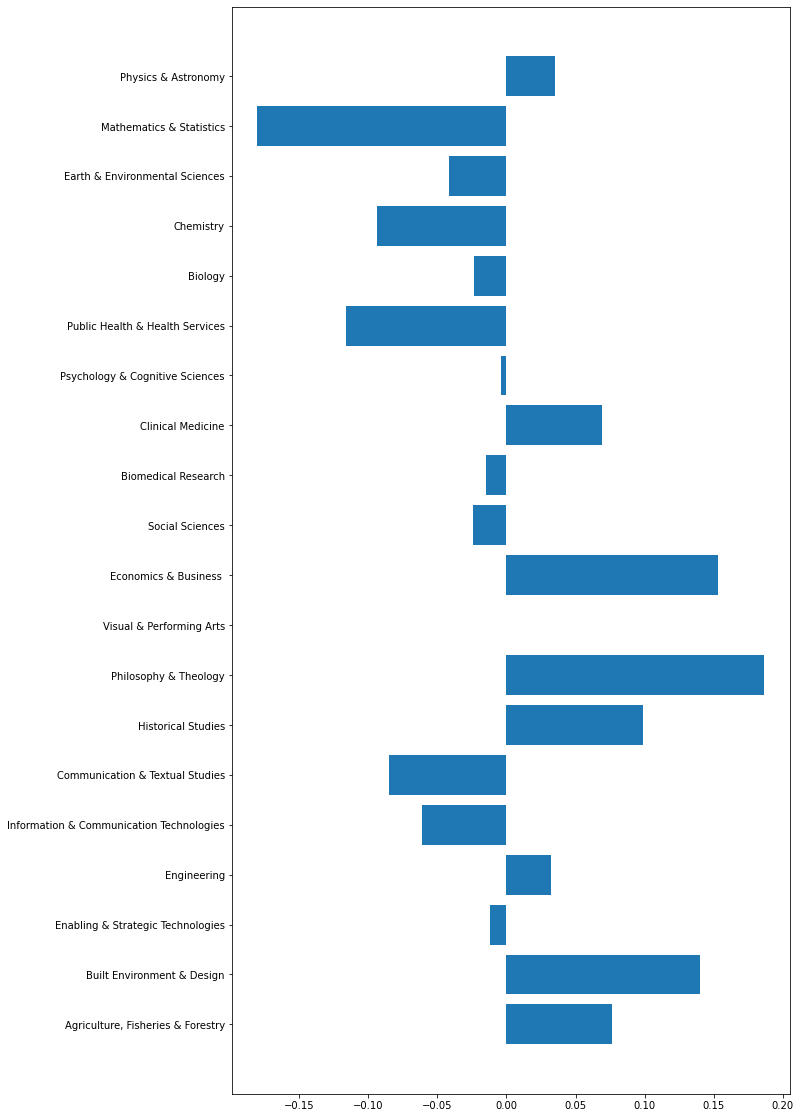

In [0]:
import matplotlib.pyplot as plt 
domain = new['Field_English'].unique()
diff = []
fig = plt.figure(figsize =(10, 20))

for i in domain:
  tc = new[new['Field_English'] == i]
  t = tc[tc['treatment'] == '1']
  c = tc[tc['treatment'] == '0']

  t_female = len(t[t['cor_gender'] == 'female']) + len(t[t['cor_gender'] == 'F']) + len(t[t['cor_gender'] == 'f'])
  c_female = len(c[c['cor_gender'] == 'female']) + len(c[c['cor_gender'] == 'F']) + len(c[c['cor_gender'] == 'f'])

  #print("domain ",i," , treatment: ",(t_female/len(t))*100, " control: ",(c_female/len(c)*100))
  diff.append(((t_female/len(t)) - (c_female/len(c)))/(c_female/len(c)))
  print(i," ",((t_female/len(t)) - (c_female/len(c)))/(c_female/len(c)), " treatment length ",len(t)," control length ",len(c))
plt.barh(domain, diff)
#print(domain)
#print(diff)

# regression analysis on journal level

In [0]:
def domain(i, new):
  a = new[new['Field_English'] == i]
  print(len(a))

  t = a[a['treatment'] == '1']
  c = a[a['treatment'] == '0']
  print("length of treatment ",len(t))
  print("length of control ",len(c))

  con_18,con_19,con_20,con_21,con_22 = [],[],[],[],[]
  t1,t2,t3,t4,t5,t6 = [],[],[],[],[],[]
  #oa = []

  out = []
  gender = []

  for ind in a.index:
    if a['year'][ind] == 2013:
      con_18.append(1)
    else:
      con_18.append(0)

    if a['treatment'][ind] == '1':
      out.append(1)
    else:
      out.append(0)

    if a['cor_gender'][ind] == 'female' or a['cor_gender'][ind] == 'f' or a['cor_gender'][ind] == 'F':
      gender.append(0)
    else:
      gender.append(1) 

  for ind in a.index:
    if a['year'][ind] == 2014:
      con_19.append(1)
    else:
      con_19.append(0)

  for ind in a.index:
    if a['year'][ind] == 2015:
      con_20.append(1)
    else:
      con_20.append(0)

  for ind in a.index:
    if a['year'][ind] == 2016:
      con_21.append(1)
    else:
      con_21.append(0)

  for ind in a.index:
    if a['year'][ind] == 2017:
      con_22.append(1)
    else:
      con_22.append(0)

  for ind in a.index:
    if a['team_size'][ind] == '1':
      t1.append(1)
    else:
      t1.append(0)

  for ind in a.index:
    if a['team_size'][ind] == '2':
      t2.append(1)
    else:
      t2.append(0)
  for ind in a.index:
    if a['team_size'][ind] == '3':
      t3.append(1)
    else:
      t3.append(0)
  for ind in a.index:
    if a['team_size'][ind] == '4':
      t4.append(1)
    else:
      t4.append(0)
  for ind in a.index:
    if a['team_size'][ind] == '5':
      t5.append(1)
    else:
      t5.append(0)

  for ind in a.index:
    if a['team_size'][ind] == '6':
      t6.append(1)
    else:
      t6.append(0)
    '''if a['openaccess_status'][ind] == 'YES':
      oa.append(1)
    else:
      oa.append(0)'''


  
  a['con_18'] = con_18
  a['con_19'] = con_19
  a['con_20'] = con_20
  a['con_21'] = con_21
  a['con_22'] = con_22
  a['outcome'] = out
  a['gender'] = gender
  a['t1'] = t1
  a['t2'] = t2
  a['t3'] = t3
  a['t4'] = t4
  a['t5'] = t5
  a['t6'] = t6
  #a['oa'] = oa

  return a
  

#ds = new[new['team_size'] == '1']

#tmp = domain("Physics & Astronomy",new) #opposite dir
#tmp = domain("Mathematics & Statistics",new) 
#tmp = domain("Earth & Environmental Sciences",new) 
#tmp = domain("Chemistry",new) #gender    0.215250   0.072440   2.971 0.00296 **
#tmp = domain("Biology",new) 
#tmp = domain("Public Health & Health Services",new) #gender 0.148472   0.032489 4.570 4.88e-06 ***
#tmp = domain("Psychology & Cognitive Sciences",new) #gender    -9.850e-02  3.504e-02 -2.811  0.00494 **
#tmp = domain("Clinical Medicine",new) 
#tmp = domain("Biomedical Research",new) 
#tmp = domain("Social Sciences",new) #opposite
#tmp = domain("Economics & Business ",new) #gender  -0.1420505  0.0592893  -2.396 0.016580 *
#tmp = domain("Visual & Performing Arts",new) ##too small sample

#tmp = domain("Philosophy & Theology",new) 
#tmp = domain("Historical Studies",new) 
#tmp = domain("Communication & Textual Studies",new) 
#tmp = domain("Information & Communication Technologies",new) 

#tmp = domain("Engineering",new) #opposite
#tmp = domain("Enabling & Strategic Technologies",new) 
#tmp = domain("Built Environment & Design",new) 
tmp = domain("Agriculture, Fisheries & Forestry",new) 

print(tmp.tail(10))

import rpy2.robjects.packages as rpackages
import rpy2.robjects.vectors as robjects_vectors


from rpy2.robjects import r, pandas2ri
import rpy2.robjects as ro
from rpy2.robjects.packages import importr

# import R's utility package
utils = rpackages.importr('utils')
utils.chooseCRANmirror(ind=1)
from rpy2.robjects.conversion import localconverter
base = importr('base')
from rpy2.robjects import Formula
stats = importr('stats')

with localconverter(ro.default_converter + pandas2ri.converter):
  tst_df = ro.conversion.py2rpy(tmp)

col_2_index = list(tst_df.colnames).index('year')
col_2 = ro.vectors.FactorVector(tst_df.rx2('year'))
tst_df[col_2_index] = col_2

col_2_index = list(tst_df.colnames).index('team_size')
col_2 = ro.vectors.FactorVector(tst_df.rx2('team_size'))
tst_df[col_2_index] = col_2


col_2_index = list(tst_df.colnames).index('q')
col_2 = ro.vectors.FactorVector(tst_df.rx2('q'))
tst_df[col_2_index] = col_2

'''col_2_index = list(tst_df.colnames).index('Field_English')
col_2 = ro.vectors.FactorVector(tst_df.rx2('Field_English'))
tst_df[col_2_index] = col_2'''

col_2_index = list(tst_df.colnames).index('subfield_article')
col_2 = ro.vectors.FactorVector(tst_df.rx2('subfield_article'))
tst_df[col_2_index] = col_2

#col_2_index = list(tst_df.colnames).index('gender')
#col_2 = ro.vectors.FactorVector(tst_df.rx2('gender'))
#tst_df[col_2_index] = col_2

#print(tst_df)
#pandas2ri.activate()
model = stats.glm("outcome ~ gender+year+q+subfield_article+team_size",
                  data=tst_df, weights = tst_df.rx2('weight'),family=ro.r('binomial(link="logit")'))
print(base.summary(model))

5871
length of treatment  900
length of control  4971
<command-2539878636054416>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a['con_18'] = con_18
<command-2539878636054416>:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a['con_19'] = con_19
<command-2539878636054416>:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable

In [0]:
new

,Domain_English,Field_English,SubField_English,srcid,openaccess_status,doi,news_cnt,year,issn,num_au,...,con_21,con_22,outcome,gender,t1,t2,t3,t4,t5,t6
7,Applied Sciences,"Agriculture, Fisheries & Forestry",agronomy & agriculture,21537,NO,10.1021/es504881t,0,2015,0013936X,7,...,0,0,0,0,0,0,0,0,1,0
10,Applied Sciences,"Agriculture, Fisheries & Forestry",agronomy & agriculture,28810,NO,10.1016/j.biombioe.2015.07.021,0,2015,09619534,5,...,0,0,0,1,0,0,0,1,0,0
14,Applied Sciences,"Agriculture, Fisheries & Forestry",agronomy & agriculture,10600153309,YES,10.1371/journal.pone.0150549,0,2016,19326203,4,...,1,0,0,1,0,0,0,1,0,0
21,Applied Sciences,"Agriculture, Fisheries & Forestry",agronomy & agriculture,38003,NO,10.1016/j.still.2016.06.007,2,2016,01671987,3,...,1,0,1,1,0,0,1,0,0,0
25,Applied Sciences,"Agriculture, Fisheries & Forestry",agronomy & agriculture,12898,NO,10.1016/j.cropro.2016.04.017,0,2016,02612194,3,...,1,0,0,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
858286,Natural Sciences,Physics & Astronomy,optics,21100200805,YES,10.1038/s41598-017-09583-6,0,2017,20452322,8,...,0,1,0,1,0,0,0,0,1,0
858288,Natural Sciences,Physics & Astronomy,optics,27030,NO,10.1063/1.4936841,0,2015,00036951,8,...,0,0,0,1,0,0,0,0,1,0
858289,Natural Sciences,Physics & Astronomy,optics,21100278313,YES,10.1038/lsa.2016.78,0,2016,20955545,9,...,1,0,0,1,0,0,0,0,1,0
858291,Natural Sciences,Physics & Astronomy,optics,21100368207,NO,10.1021/acsphotonics.7b00351,0,2017,23304022,5,...,0,1,0,1,0,0,0,1,0,0


In [0]:
total[total['doi'] == '10.1038/ncomms8459']

,Domain_English,Field_English,SubField_English,srcid,openaccess_status,doi,news_cnt,year,issn,num_au,cor_gender,TopicId,Au1_gender,country_name,SJR,subfield_article,preferred_name,org_type
857340,Natural Sciences,Physics & Astronomy,optics,19700182758,YES,10.1038/ncomms8459,4,2015,20411723,6,male,24006,male,United States,6.287,optics,Lawrence Berkeley National Laboratory,resi


In [0]:
df_ani = spark.read.format("parquet").load(basePath+tablename_ani)
a = df_ani.filter(func.col('doi') == '10.1016/j.indcrop.2012.03.036')
display(a)

In [0]:
def extract_publication_info(newdf):
  #newdf = df_ani.limit(50)
  newdf = newdf.select('doi','Eid','year','Au','Au_Af','Au_cors','publication_type','openaccess','issn','source','correspondence','Af')


  newdf = newdf.withColumn('Au1', first(newdf['Au']))



  newdf = newdf.withColumn('Au2', F.element_at(newdf['Au'], -1))

  newdf = newdf.withColumn('num_au', F.size(newdf['Au']))

  newdf = newdf.withColumn('Au1_id', F.col('Au1').getItem('auid'))

  newdf = newdf.withColumn('Au2_id', F.col('Au2').getItem('auid'))

  newdf = newdf.withColumn('Au_cor_id', F.col('Au_cors').getItem('auid'))
  newdf = newdf.withColumn('Au_cor_name', F.col('Au_cors').getItem('given_name'))
  newdf = newdf.withColumn('cor1_given_name', first(newdf['Au_cor_name']))

  newdf = newdf.withColumn('cor_seq', F.col('Au_cors').getItem('Authorseq'))
  newdf = newdf.withColumn('cor_seq_first', first(newdf['cor_seq']))
  newdf = newdf.withColumn('given_seq', F.col('Au').getItem('given_name'))
  newdf = newdf.withColumn("given_seq_cor", F.element_at(newdf['given_seq'], newdf['cor_seq_first']))
  #newdf = newdf.withColumn("aff_val", F.element_at(newdf['Af'], newdf['aff']))
  display(newdf.limit(10))

df_ani = spark.read.format("parquet").load(basePath+tablename_ani)
extract_publication_info(df_ani)

doi,Eid,year,Au,Au_Af,Au_cors,publication_type,openaccess,issn,source,correspondence,Af,Au1,Au2,num_au,Au1_id,Au2_id,Au_cor_id,Au_cor_name,cor1_given_name,cor_seq,cor_seq_first,given_seq,given_seq_cor
10.1007/s13204-021-01692-z,85102837516,2022,"List(List(1, 6507875100, auth, false, null, 96fc0f1c4247f8e55c85951579edfdae3114da9a, Nataliya, Nataliya, Kusyak N., Kusyak N., N., N., null, 0000-0002-0143-3399, null, Kusyak, Kusyak), List(2, 57216653360, auth, false, null, null, Andrii, Andrii, Kusyak A., Kusyak A., A., A., null, null, null, Kusyak, Kusyak), List(3, 55800693100, auth, false, null, null, Alla, Alla, Petranovska A., Petranovska A., A., A., null, null, null, Petranovska, Petranovska), List(4, 6701797242, auth, false, null, null, Petro, Petro, Gorbyk P., Gorbyk P., P., P., null, null, null, Gorbyk, Gorbyk), List(5, 7004245037, auth, false, null, null, Nicolay, Nicolay, Abramov N., Abramov N., N., N., null, null, null, Abramov, Abramov))","List(List(1, 1, true), List(2, 2, true), List(3, 2, true), List(4, 2, true), List(5, 2, true))","List(List(1, 6507875100, null, false, null, null, Nataliya, null, Kusyak N., null, N., null, null, null, null, Kusyak, null))",ar,None,21905509,"List(null, null, che, 01, 03, March 2022, 2022, null, null, null, null, null, List(21905517), null, List(21905509), Springer Science and Business Media Deutschland GmbH, Applied Nanoscience (Switzerland), Appl. Nanosci. (Switzerland), 21100886227, j, https://rd.springer.com/journal/13204)","List(List(ukr, null))","List(List(40 Velyka Berdychivska St, Zhytomyr, null, Ukraine, List(60104091), List(Department of Chemistry, Ivan Franko Zhytomyr State University), 2, 10008, null, ukr, null, 60104091, 124359559), List(17 General Naumov Street, Kiev, null, Ukraine, List(60011313, 60068511), List(Chuiko Institute of Surface Chemistry, National Academy of Science of Ukraine), 2, 03164, null, ukr, null, 60068511, null))","List(1, 6507875100, auth, false, null, 96fc0f1c4247f8e55c85951579edfdae3114da9a, Nataliya, Nataliya, Kusyak N., Kusyak N., N., N., null, 0000-0002-0143-3399, null, Kusyak, Kusyak)","List(5, 7004245037, auth, false, null, null, Nicolay, Nicolay, Abramov N., Abramov N., N., N., null, null, null, Abramov, Abramov)",5,6507875100,7004245037,List(6507875100),List(Nataliya),Nataliya,List(1),1,"List(Nataliya, Andrii, Alla, Petro, Nicolay)",Nataliya
10.1097/00005650-200209000-00007,36717780,2002,"List(List(1, 35378854900, null, false, null, a7d8fd447b21455456b14b85e3283d5a3140b2f0, Christopher M., Christopher M., Callahan C.M., Callahan C.M., C.M., C.M., null, null, null, Callahan, Callahan), List(2, 35481291100, null, false, null, null, Frederick W., Frederick W., Unverzagt F.W., Unverzagt F.W., F.W., F.W., null, null, null, Unverzagt, Unverzagt), List(3, 7202831850, null, false, null, null, Siu L., Siu L., Hui S.L., Hui S.L., S.L., S.L., null, null, null, Hui, Hui), List(4, 7102761843, null, false, null, null, Anthony J., Anthony J., Perkins A.J., Perkins A.J., A.J., A.J., null, null, null, Perkins, Perkins), List(5, 7004923246, null, false, null, null, Hugh C., Hugh C., Hendrie H.C., Hendrie H.C., H.C., H.C., null, null, null, Hendrie, Hendrie))","List(List(1, 1, true), List(3, 1, true), List(4, 1, true), List(5, 1, true), List(1, 2, true), List(3, 2, true), List(4, 2, true), List(5, 2, true), List(2, 3, true), List(5, 3, true), List(1, 4, true))","List(List(1, 35378854900, null, false, Dr., null, null, null, Callahan C.M., null, C.M., null, null, null, null, Callahan, null))",ar,None,00257079,"List(null, null, usa, null, 09, September 2002, 2002, null, null, null, null, null, null, null, List(00257079), null, Medical Care, Med. Care, 17785, j, null)","List(List(usa, null))","List(List(null, null, Indianapolis, IN, United States, List(60024609, 60021947, 60002543), List(Indiana University, Center for Aging Research, Indiana University School of Medicine), 3, null, null, usa, null, 60024609, null), List(null, null, Indianapolis, IN, United States,

In [0]:
t = new[new['treatment'] == '1']
f1 = t[t['cor_gender'] == 'female']
f2 = t[t['cor_gender'] == 'F']
f3 = t[t['cor_gender'] == 'f']
f1 = f1.append(f2, ignore_index=True)
f1 = f1.append(f3, ignore_index=True)
print(f1['news_cnt'].mean())

m1 = t[t['cor_gender'] == 'male']
m2 = t[t['cor_gender'] == 'M']
m3 = t[t['cor_gender'] == 'm']
m1 = m1.append(m2, ignore_index=True)
m1 = m1.append(m3, ignore_index=True)
print(m1['news_cnt'].mean())

8.599069274715296
8.163735803109843
